In [1]:
import numpy as np

In [2]:
%env JAX_ENABLE_X64=True

env: JAX_ENABLE_X64=True


In [3]:
from lenstronomy.LensModel.lens_model import LensModel
import lensinggw.constants.constants as const
from lensinggw.utils.utils import TimeDelay, magnifications, getMinMaxSaddle

In [17]:
import sys
sys.path.insert(0, '../wolensing/')

In [4]:
from plot.plot import plot_contour
import amplification_factor.amplification_factor as af

The macroimage where the microlens is placed around.

In [5]:
type2 = False

In [6]:
ym = 0.5
angle = np.radians(float(0))

Importing constants

In [7]:
G = const.G  # gravitational constant [m^3 kg^-1 s^-2]
c = const.c  # speed of light [m/s]
M_sun = const.M_sun  # Solar mass [Kg]

In [8]:
y0, y1 = 0.5, 0 # source position
l0, l1 = 0., 0 # lens position

zS = 1.0 # source redshift
zL = 0.5 # lens redshift

In [9]:
mL1 = 1 * 1e10
mL2 = 100
mtot = mL1 + mL2

# convert to radians
from lensinggw.utils.utils import param_processing
thetaE1 = param_processing(zL, zS, mL1)
thetaE2 = param_processing(zL, zS, mL2)
thetaE = param_processing(zL, zS, mtot)

In [10]:
beta0, beta1 = y0 * thetaE, y1 * thetaE
eta10, eta11 = 0 * l0 * thetaE, 0 * l1 * thetaE
lens_model_list = ['SIS']
kwargs_sis_1 = {'center_x': eta10, 'center_y': eta11, 'theta_E': thetaE1}
kwargs_lens_list = [kwargs_sis_1]

kwargs_sis_1_scaled = {'center_x': eta10 / thetaE, 'center_y': eta11 / thetaE, 'theta_E': thetaE1 / thetaE}
kwargs_lens_list_scaled = [kwargs_sis_1_scaled]

from lensinggw.solver.images import microimages
solver_kwargs = {'SearchWindowMacro': 10 * thetaE1,
                 'SearchWindow': 5 * thetaE2,
                 'OverlapDistMacro': 1e-17,
                 'OnlyMacro': True}
MacroImg_ra, MacroImg_dec, pixel_width = microimages(source_pos_x=beta0,
                                                     source_pos_y=beta1,
                                                     lens_model_list=lens_model_list,
                                                     kwargs_lens=kwargs_lens_list,
                                                     **solver_kwargs)

Td = TimeDelay(MacroImg_ra, MacroImg_dec,
                beta0, beta1,
                zL, zS,
                lens_model_list, kwargs_lens_list)
Mus = magnifications(MacroImg_ra, MacroImg_dec, lens_model_list, kwargs_lens_list)
if type2:
    microtype = np.nonzero(Td)[0][0]
else:
    microtype = np.where(Td==0)[0][0]

# Injecting microlens around desired macroimage
eta20, eta21 = MacroImg_ra[microtype] + np.cos(angle)*ym*thetaE2, MacroImg_dec[microtype] + np.sin(angle)*ym*thetaE2
lens_model_list = ['SIS', 'POINT_MASS']
kwargs_sis_1 = {'center_x': eta10, 'center_y': eta11, 'theta_E': thetaE1}
kwargs_point_mass_2 = {'center_x': eta20, 'center_y': eta21, 'theta_E': thetaE2}
kwargs_lens_list = [kwargs_sis_1, kwargs_point_mass_2]

from lensinggw.solver.images import microimages
solver_kwargs = {'SearchWindowMacro': 10 * thetaE1,
                 'SearchWindow': 10 * thetaE2,
                 'Pixels': 1e3,
                 'OverlapDist': 1e-18,
                 'OverlapDistMacro': 1e-17}
solver_kwargs.update({'Improvement' : 0.1})
solver_kwargs.update({'MinDist' : 10**(-7)})

Img_ra, Img_dec, MacroImg_ra, MacroImg_dec, pixel_width = microimages(source_pos_x=beta0,
                                                                      source_pos_y=beta1,
                                                                      lens_model_list=lens_model_list,
                                                                      kwargs_lens=kwargs_lens_list,
                                                                      **solver_kwargs)
Images_dict = {'Source_ra': beta0,
               'Source_dec': beta1,
               'Img_ra': Img_ra,
               'Img_dec': Img_dec,
               'MacroImg_ra': MacroImg_ra,
               'MacroImg_dec': MacroImg_dec,
               'Microlens_ra': [eta20],
               'Microlens_dec': [eta21],
               'thetaE': thetaE}

# time delays, magnifications, Morse indices 
from lensinggw.utils.utils import TimeDelay, magnifications, getMinMaxSaddle
from lensinggw.amplification_factor.amplification_factor import geometricalOpticsMagnification
tds = TimeDelay(Img_ra, Img_dec,
               beta0, beta1,
               zL, zS,
               lens_model_list, kwargs_lens_list)
mus = magnifications(Img_ra, Img_dec, lens_model_list, kwargs_lens_list)
ns = getMinMaxSaddle(Img_ra, Img_dec, lens_model_list, kwargs_lens_list, diff = None)
print('Time delays (seconds): ', tds)
print('magnifications: ', mus)
print('Morse indices: ', ns)
    
lens_model_complete = LensModel(lens_model_list=lens_model_list)
T = lens_model_complete.fermat_potential
T0 = thetaE ** (-2) * T(Img_ra[microtype], Img_dec[microtype], kwargs_lens_list, beta0, beta1)#[0]
if not isinstance(T0, float):
    T0 = T0[0]
Tscale = 4 * (1 + zL) * mtot * M_sun * G / c ** 3
print('T0 = {}'.format(T0))
print('Tscale = {}'.format(Tscale))

/home/manchun.yeung/.conda/envs/wolensing/lib/python3.10/site-packages/lensinggw-1.0.0-py3.10.egg/lensinggw/solver/images.py:107: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/home/manchun.yeung/.conda/envs/wolensing/lib/python3.10/site-packages/lensinggw-1.0.0-py3.10.egg/lensinggw/solver/images.py:107: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/manchun.yeung/.conda/envs/wolensing/lib/python3.10/site-packages/lensinggw-1.0.0-py3.10.egg/lensinggw/solver/images.py:108: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/manchun.yeung/.conda/envs/wolensing/lib/python3.10/site-packages/lensinggw-1.0.0-py3.10.egg/lensinggw/solver/images.py:117: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/home/manchun.yeung/.conda/envs/wolensing/lib/python3.10/site-packages/lensinggw-1.0.0-py3.10.egg/lensinggw/solver/images.py:117: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/manchun.yeung/.conda/envs/wolensing/lib/python3.10/site-packa


---- Will perform only the macromodel analysis ----

---- Solver settings ----

The macromodel analysis will be performed with the following settings:

OnlyMacro         --> True
Scaled            --> False
SearchWindowMacro --> 8.052888061582412e-06
PixelsMacro       --> 1000
PrecisionLimit    --> 1e-20
OverlapDistMacro  --> 1e-17
NearSource        --> False
Optimization      --> False
Verbose           --> False




MACROIMAGES

ra: [-4.02644401e-07  1.20793321e-06]
dec: [-4.23516474e-22 -4.23516474e-22]


---- Solver settings ----

The macromodel analysis will be performed with the following settings:

OnlyMacro         --> False
Scaled            --> False
SearchWindowMacro --> 8.052888061582412e-06
PixelsMacro       --> 1000
PrecisionLimit    --> 1e-20
OverlapDistMacro  --> 1e-17
NearSource        --> False
Optimization      --> False
Verbose           --> False




MACROIMAGES

ra: [-4.02644401e-07  1.20793321e-06]
dec: [-4.23516474e-22 -4.23516474e-22]


---- Solver settings --

In [11]:
# plot only the microimages around the desired macroimage
Img_ra = np.delete(Img_ra, [0])
Img_dec = np.delete(Img_dec, [0])

[-4.02644401e-07  1.20793321e-06] [-4.23516474e-22 -4.23516474e-22] Img_pos


<Axes: >

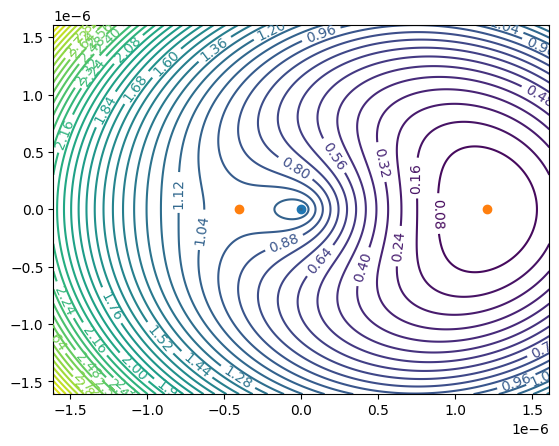

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plot_contour(ax, lens_model_list, eta10, eta11, 4*thetaE1, kwargs_lens_list, beta0, beta1, MacroImg_ra, MacroImg_dec,
                    T0 = T0, Tfac = (thetaE)**(-2), micro=False)


[1.20791307e-06 1.20787034e-06 1.20803635e-06 1.20791307e-06] [-1.25725593e-10 -4.12728663e-22 -4.12728663e-22  1.25725593e-10] Img_pos


<Axes: >

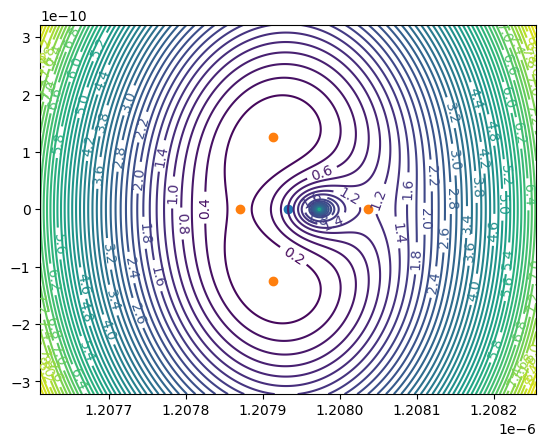

In [13]:
fig1, ax1 = plt.subplots()
plot_contour(ax1, lens_model_list, MacroImg_ra[microtype], MacroImg_dec[microtype], 8*thetaE2, kwargs_lens_list, beta0, beta1, Img_ra, Img_dec,
                    T0 = T0, Tfac = (thetaE)**(-2), micro=True)


In [14]:
# Define the characteristic WindowSize
mL3 = 10
thetaE3 = param_processing(zL, zS, mL3)

In [15]:
import time

In [16]:
kwargs_macro = {'source_pos_x': beta0,
                'source_pos_y': beta1,
                'theta_E': thetaE,
                'mu': Mus[microtype],
               }

kwargs_integrator = {'PixelNum': int(20000),
                     'PixelBlockMax': 2000,
                     'WindowSize': 1.5*210*thetaE3,
                     'WindowCenterX': MacroImg_ra[microtype],
                     'WindowCenterY': MacroImg_dec[microtype],
                     'T0': T0,
                     'TimeStep': 1e-5/Tscale, 
                     'TimeMax': T0 + 1/Tscale,
                     'TimeMin': T0 - .1/Tscale,
                     'TimeLength': 2/Tscale,
                     'TExtend': 10/Tscale,
                     'LastImageT': .02/Tscale,
                     'Tbuffer': 0,
                     'Tscale': Tscale}


amplification = af.amplification_factor(lens_model_list=lens_model_list, kwargs_lens=kwargs_lens_list, kwargs_macro=kwargs_macro, **kwargs_integrator)
amplification.integrator(gpu=True)
ws, Fws = amplification.fourier()
amplification.plot_freq()

start


Integrating...:   0%|          | 0/121 [00:00<?, ?it/s]


TypeError: cannot reshape array of shape (2,) (size 2) into shape (2, 2000, 2000) (size 8000000)

In [ ]:
amplification.plot_freq(pha=True)

# Geometrical optics
To get the geometrical optics around type 1 image, we need the magnifications, time delay and the image positions of the microimages

In [ ]:
mus = mus[1:]
tds = tds[1:]

In [ ]:
geofs, geoFws = amplification.geometrical_optics(mus, tds, Img_ra, Img_dec)

In [ ]:
plt.semilogx(geofs, np.abs(geoFws))

# Full amplification factor concatenated with geometrical optics
Given the computaional cost of the diffraction integral, we concatenate the result of wave optics at low frequency and geometrical optics at high frequency to obtain a full amplification factor with default upper bound of 3000Hz.

In [ ]:
fullfs, fullFws = amplification.concatenate()
plt.semilogx(fullfs, np.abs(fullFws))

In [ ]:
plt.semilogx(fullfs, np.angle(fullFws))